# California Housing Prices

> The content of this notebook is based on the book **Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow 2nd**, Chapter 2.

This dataset is based on data from 1990 California census.

## Frame the Problem

A Machine Learning pipeline for real estate investments

![](https://i.imgur.com/cgtQWuB.png)

> Pipelines
> A sequence of data processing components is called a data pipeline. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.
>
> Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store. Then, some time later, the next component in the pipeline pulls this data and spits out its own output. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.
>
> On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance drops.

### Select a Performance Measure

Your next step is to select a performance measure. Because this is a regression problem, the metric we choose is **Root Mean Square Error (RMSE)**

## Get the Data

You could use your web browser to download the file and run tar xzf `housing.tgz` to decompress it and extract the CSV file, but it is preferable to create a small function to do that. Having a function that downloads the data is useful in particular if the data changes regularly: you can write a small script that uses the function to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals). Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

**Import data and libraries**

In [ ]:
#@title Import data and Libraries
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)  
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()


In [ ]:
# Run this to view our data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.shape

(20640, 10)

### Take a Quick Look at the Data Struture

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing['total_bedrooms'].isna().sum()

207

In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**First Overview:**

* Each value represents  one district.
* There are ten attributes.
* `total_bedrooms` has only 20.433 nonnull values, meaning that 207 districts are missing this feature.
* All attributes are numerical, except the `ocean_proximity` field.

Next let's take a look at a histogram for each numerical attribute. You can call the `hist()` method on the whole dataset, and it will plot a histogram for each numerical attribute.

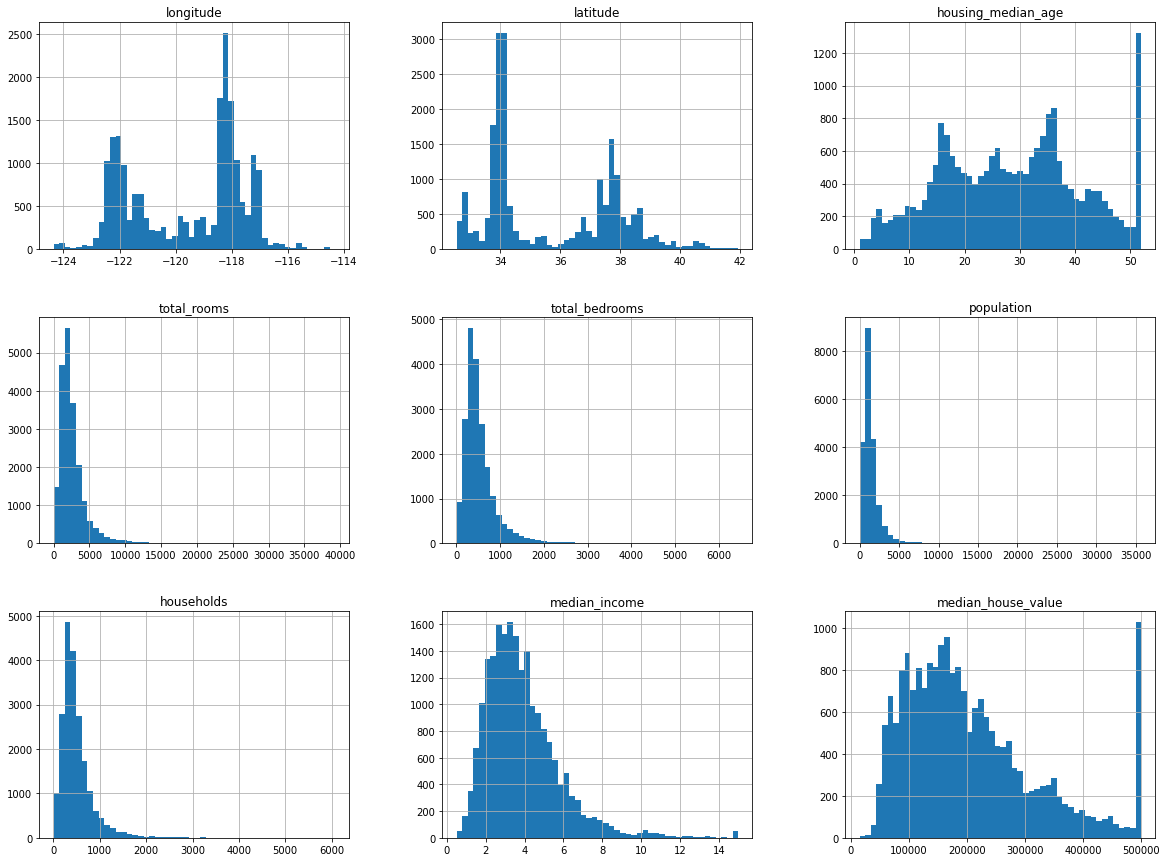

In [ ]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

**There are a few things to notice in these histograms:**

* Does the median income attribute look like it is expressed in USD? 
=> It look like this feature is scaled to the range (0.4999, 15.0001)

*Please answer here:*

* In your opinion, what is the reason for those tall bins at the end for housing median age and the median house value?

=> They both are scaled.
=> The median house value is important because it is label.

*Please answer here:*

* Are the attributes having similar scales?
=> I think they have minmaxscaler with different range

*Please answer here:*


* Note: Many histogram are tail-heavy (skewness). This may make it harder for some ML algorithms to detect patterns. We will try transforming these attributes to have more bell-shaped distributions.

Let's take a look at the correlation

In [ ]:
housing[housing.columns[~housing.columns.isin(['ocean_proximity'])]]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


In [ ]:
# Get the correlation matrix of dataframe
housing.corr().style.background_gradient(cmap='PRGn')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [ ]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [ ]:
table_corr = pd.DataFrame(housing.corr())

In [ ]:
table_corr[['median_house_value']].sort_values('median_house_value',ascending=False).index[1]

'median_income'

### Create a Test Set

We can use `sklearn.train_test_split` to have a random sampling

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

But it's not perfect. We might run the risk of introducing a significant sampling-bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.

We know that median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing['income_cat']

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

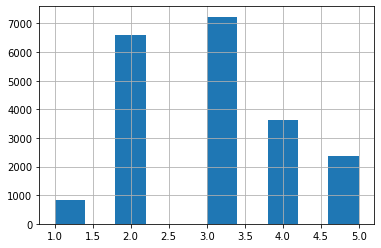

In [ ]:
housing["income_cat"].hist()

In [ ]:
housing["income_cat"].shape

(20640,)

In [ ]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [ ]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


In [ ]:
train_set.shape

(16512, 10)

In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

In [ ]:
train_set['income_cat'].value_counts()

3    5789
2    5265
4    2911
5    1889
1     658
Name: income_cat, dtype: int64

In [ ]:
test_set['income_cat'].value_counts()

3    1447
2    1316
4     728
5     473
1     164
Name: income_cat, dtype: int64

In [ ]:
train_set["income_cat"].value_counts(normalize=True)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [ ]:
test_set["income_cat"].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Now you should remove the income_cat attribute so the data is back to its original state:

In [ ]:
train_set = train_set.drop("income_cat", axis=1)
test_set = test_set.drop("income_cat", axis=1)

In [ ]:
test_set.shape

(4128, 10)

## Discover and Visualize the Data to Gain Insights

First, make sure you have put the test set aside and you are only exploring the training set. Let's create a copy so that you can play with the training set without harming it:

In [ ]:
housing = train_set.copy()

### Visualize Geographical Data

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure bad_visualization_plot


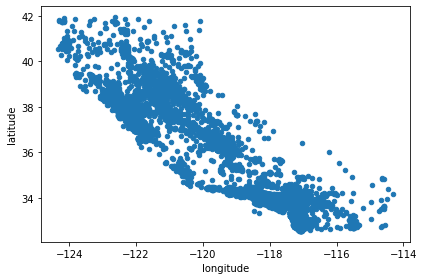

In [ ]:
housing.plot(kind='scatter', x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


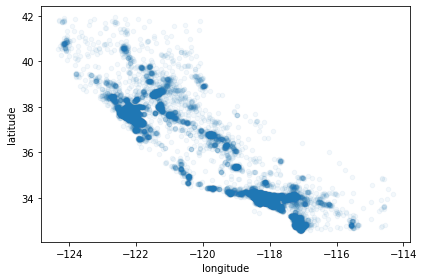

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.05)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


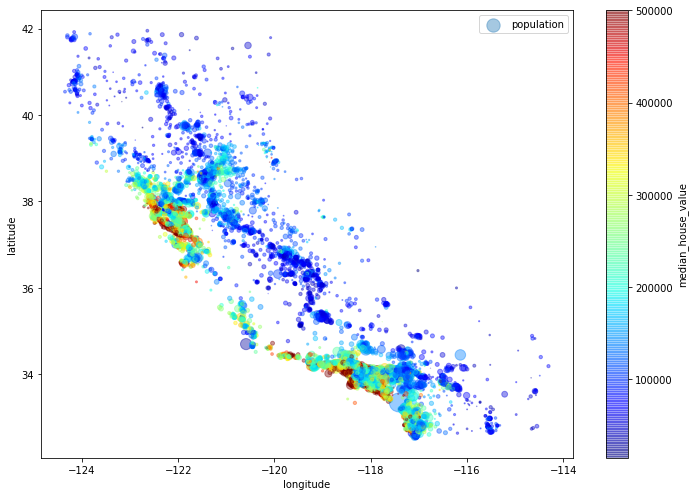

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

* Most expensive house gather near the ocean. Population gathers near the ocean too.
* The other are the median house value are quite similar.

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/california.png', <http.client.HTTPMessage at 0x7f3520d7d090>)

Saving figure california_housing_prices_plot


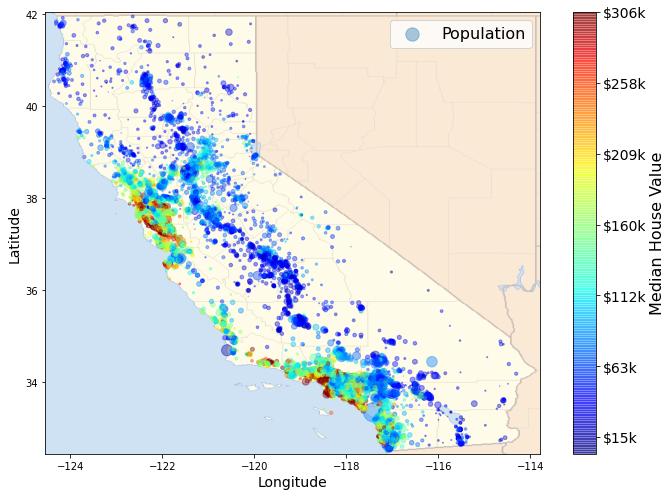

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Looking for Correlations

> **WARNING:** The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to 0, then y generally goes up”). 

In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page—so let’s just focus on a few promising attributes that seem most correlated with the median housing value

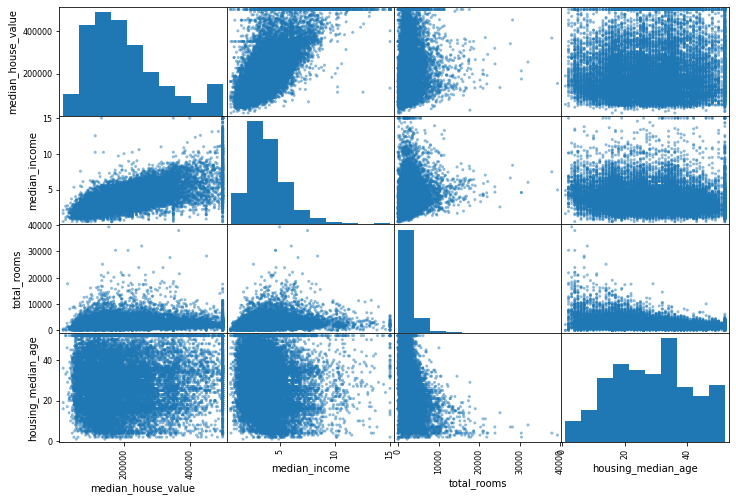

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

# seaborn also has a similiar function for this plot
# sns.pairplot(housing[attributes])

plt.show()

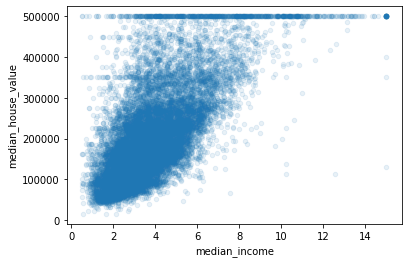

In [ ]:
# The most promising attribute to predict the median house value is the median income

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

**This plot reveals a few things:**
* The correlation is indeed very strong.
* The price cap is clearly visible as a horizontal line at `$500,000`
* But this plot reveals other less obvious straight lines: a horizontal line around `$450,000`, another around `$350,000`

### Experimenting with Attribute Combinations

There are a few things we could try manipulating the data before training ML algorithms. Example, the number of rooms in a district is not very useful. What we really want is the number of rooms per household. Similiar with the total number of bedrooms, we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [ ]:
housing['households']

17606     339.0
18632     113.0
14650     462.0
3230      353.0
3555     1463.0
          ...  
6563      210.0
12053     258.0
13908     765.0
11159     356.0
15775     639.0
Name: households, Length: 16512, dtype: float64

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Not bad! The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a **lower** bedroom/room ratio tend to be more expensive (notice the negative sign). The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

> This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## Prepare the Data for ML algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose.

In [ ]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

In [ ]:
housing_test = test_set.copy().drop("median_house_value", axis=1)
housing_labels_test = test_set["median_house_value"].copy()

In [ ]:
housing_labels_test.shape

(4128,)

### Data Cleaning

We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. We have 3 options:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

In [ ]:
median = housing["total_bedrooms"].median()

Here we choose option 3, we should compute the median value on the training set and use it to fill the missing values in the training set. 

> Don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# the median can only be computed on numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [ ]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


Now you can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [ ]:
X = imputer.transform(housing_num)

# The result is a plain NumPy array containing the transformed features. 
# If you want to put it back into a pandas DataFrame:
pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [ ]:
k_check = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [ ]:
k_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### Handling Categorical Attributes


In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

print(housing_cat[:10])
print(housing_cat_encoded[:10])
print(f"Encoder's categories {ordinal_encoder.categories_}")

      ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN
[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
Encoder's categories [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

> Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array,21 but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformer

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        
        # concatenate newly created columns to the existing numpy array X
        return np.c_[X, rooms_per_household, population_per_household,
                      bedrooms_per_room]


attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs.shape

(16512, 12)

In [ ]:
housing.shape

(16512, 9)

### Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale: `min-max scaling`(normalization) and `standardization`.

* Min-Max-Scaling: values are shifted so that they end up ranging from 0 to 1. Scikit-learn provides a transformer called `MinMaxScaler` for this.
* Standardization: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Standardization does not bound values to a specific range, and is much less affected by outliers. Scikit-learn provides a transformer called `StandardScaler` for this.

### Transformation Pipeline

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

SimpleImputer           --> Fill median values for total_bedrooms feature

CombinedAttributesAdder --> Generate rooms_per_household, population_per_household, bedrooms_per_room

StandardScaler          --> Scale the range for all numerical columns

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared.shape

(16512, 16)

In [ ]:
housing_prepared_test = full_pipeline.fit_transform(housing_test)

In [ ]:
housing_prepared_test.shape

(4128, 16)

> **Tip:** Instead of using a transformer, you can specify the string "drop" if you want the columns to be dropped, or you can specify "passthrough" if you want the columns to be left untouched. By default, the remaining columns (i.e., the ones that were not listed) will be dropped, but you can set the remainder hyperparameter to any transformer (or to "passthrough") if you want these columns to be handled differently.

## Select and Train a Model

Now using `housing_prepared` and `housing_labels` to train model. Remember to use **Root Mean Squared Error** as your metric

### Using LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Define estimator
estimator_Linear = LinearRegression()

In [ ]:
estimator_Linear.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
print(estimator_Linear.coef_) # weights
print(estimator_Linear.intercept_) # bias

[-55650.4116403  -56716.45236929  13732.83841856  -1933.1277138
   7330.04062103 -45708.26306673  45455.47519691  74714.39134154
   6605.12802802   1042.95709453   9249.75886697 -18016.52432168
 -55219.15208555 110357.78363967 -22479.84008184 -14642.2671506 ]
236914.99732815978


In [ ]:
# Predict on housing_prepared
housing_labels_predict = estimator_Linear.predict(housing_prepared)

In [ ]:
housing_labels_predict

array([210644.60459286, 317768.80697211, 210956.43331178, ...,
        95464.57062437, 214353.22541713, 276426.4692067 ])

In [ ]:
MSE = mean_squared_error(housing_labels,housing_labels_predict)

In [ ]:
RMSE_Linear_Regression = np.sqrt(MSE)
RMSE_Linear_Regression

68628.19819848923

In [ ]:
# Predict
# housing_labels_predict = estimator_Linear.predict(housing_prepared)
print(f'RMSE on train set: {RMSE_Linear_Regression}')

housing_labels_test_predict = estimator_Linear.predict(housing_prepared_test)
print(f'RMSE on validation set: {np.sqrt(mean_squared_error(housing_labels_test, housing_labels_test_predict))}')

RMSE on train set: 68628.19819848923
RMSE on validation set: 66973.71087993948


##### **RMSE of Linear Regrssion = 68628.2**

In [ ]:
# Return the coefficient of determination of the prediction. R^2 score
estimator_Linear.score(housing_prepared,housing_labels)

0.6481624842804428

In [ ]:
full_pipeline.named_transformers_['cat'].categories_[0]

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(full_pipeline.named_transformers_["cat"].categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(attributes)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


In [ ]:
attributes.index('housing_median_age')

2

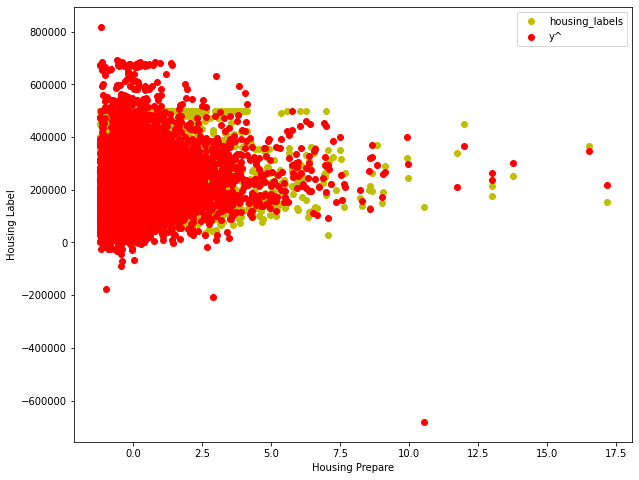

In [ ]:
#Plot the lable and prediction

# line_x = np.arange(-1, 7)
plt.figure(figsize=(10, 8))
# draw_grid(x_lim=np.array([-1, 6]), y_lim=np.array([-1, 25]))

plt.scatter(housing_prepared[:, np.newaxis, 3], housing_labels,c='y', label='housing_labels')
plt.scatter(housing_prepared[:, np.newaxis, 3], housing_labels_predict, c='r', label='y^')
# plt.plot(line_housing_prepared, line_lr(line_x), c='r')
# for i, y_i in enumerate(y):
#     plt.plot([i, i], [y_i, line_lr(i)], linestyle='--', c='g')
# plt.title(f'Loss function L(w,b) = {mse(y, y_hat):.1f} \n for y^={w}x + {b}', fontsize=18)

plt.xlabel('Housing Prepare')
plt.ylabel('Housing Label')
plt.legend()
plt.show()

### Using Polynorminal Regression

In [ ]:
# Import
from sklearn.preprocessing import PolynomialFeatures
# Ridge regression or L2
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define Pipeline
final_pipe_poly_Ridge = Pipeline(steps=[
                       ('preprocessor', full_pipeline),
                       ('poly',PolynomialFeatures(include_bias=False)),
                       ('model_Ridge', Ridge())
                        ]
                      )

In [ ]:
for i in final_pipe_poly_Ridge.get_params().keys():
    print(i)

memory
steps
verbose
preprocessor
poly
model_Ridge
preprocessor__n_jobs
preprocessor__remainder
preprocessor__sparse_threshold
preprocessor__transformer_weights
preprocessor__transformers
preprocessor__verbose
preprocessor__num
preprocessor__cat
preprocessor__num__memory
preprocessor__num__steps
preprocessor__num__verbose
preprocessor__num__imputer
preprocessor__num__attribs_adder
preprocessor__num__std_scaler
preprocessor__num__imputer__add_indicator
preprocessor__num__imputer__copy
preprocessor__num__imputer__fill_value
preprocessor__num__imputer__missing_values
preprocessor__num__imputer__strategy
preprocessor__num__imputer__verbose
preprocessor__num__std_scaler__copy
preprocessor__num__std_scaler__with_mean
preprocessor__num__std_scaler__with_std
preprocessor__cat__categories
preprocessor__cat__drop
preprocessor__cat__dtype
preprocessor__cat__handle_unknown
preprocessor__cat__sparse
poly__degree
poly__include_bias
poly__interaction_only
poly__order
model_Ridge__alpha
model_Ridge__c

In [ ]:
# Parameters
alpha_Ridge = np.logspace(-5, 3, num=10)

params_poly_Ridge = {'model_Ridge__alpha':alpha_Ridge,
                     'poly__degree':np.arange(1,4)}

In [ ]:
GSC_poly_ridge = GridSearchCV(estimator = final_pipe_poly_Ridge, 
                   param_grid = params_poly_Ridge,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   cv = 5,
                   verbose=5)
GSC_poly_ridge.fit(housing,housing_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   32.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
cv_poly_Ridge = pd.DataFrame(GSC_poly_ridge.cv_results_)
cv_poly_Ridge = cv_poly_Ridge.sort_values('rank_test_score')
for rec in cv_poly_Ridge[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score:{rec[1]:.5f} +- {rec[2]:.5f}')
    print('-'*10)

Rank 1
Params: {'model_Ridge__alpha': 16.681005372000556, 'poly__degree': 1}
Mean score:-4780604289.81242 +- 300308668.22234
----------
Rank 2
Params: {'model_Ridge__alpha': 0.2782559402207126, 'poly__degree': 1}
Mean score:-4781083084.30233 +- 304554353.42415
----------
Rank 3
Params: {'model_Ridge__alpha': 0.03593813663804626, 'poly__degree': 1}
Mean score:-4781176005.11184 +- 304612996.13540
----------
Rank 4
Params: {'model_Ridge__alpha': 0.004641588833612777, 'poly__degree': 1}
Mean score:-4781201168.73400 +- 304623234.73067
----------
Rank 5
Params: {'model_Ridge__alpha': 0.0005994842503189409, 'poly__degree': 1}
Mean score:-4781204729.60649 +- 304624623.18537
----------


##### So the hyperparameter alpha in range (10^-4,17) and poly degree = 1

In [ ]:
# Parameters_Ridge_1
alpha_Ridge_1 = np.linspace(-0.005,17, num=5)

In [ ]:
alpha_Ridge_1

array([-5.000000e-03,  4.246250e+00,  8.497500e+00,  1.274875e+01,
        1.700000e+01])

In [ ]:
params_poly_Ridge_1 = {'model_Ridge__alpha':alpha_Ridge_1,
                     'poly__degree':np.arange(1,4)}

GSC_poly_ridge_1 = GridSearchCV(estimator = final_pipe_poly_Ridge, 
                   param_grid = params_poly_Ridge_1,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   cv = 5,
                   verbose=5)

In [ ]:
GSC_poly_ridge_1.fit(housing,housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   33.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
cv_poly_Ridge_1 = pd.DataFrame(GSC_poly_ridge_1.cv_results_)
cv_poly_Ridge_1 = cv_poly_Ridge_1.sort_values('rank_test_score')
for rec in cv_poly_Ridge_1[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score:{rec[1]:.5f} +- {rec[2]:.5f}')
    print('-'*10)

Rank 1
Params: {'model_Ridge__alpha': 17.0, 'poly__degree': 1}
Mean score:-4780578521.12023 +- 300221936.88741
----------
Rank 2
Params: {'model_Ridge__alpha': 12.74875, 'poly__degree': 1}
Mean score:-4780930446.09963 +- 301388988.42949
----------
Rank 3
Params: {'model_Ridge__alpha': -0.005, 'poly__degree': 1}
Mean score:-4781209786.72390 +- 304626573.21661
----------
Rank 4
Params: {'model_Ridge__alpha': 8.497499999999999, 'poly__degree': 1}
Mean score:-4781273634.65073 +- 302571254.94302
----------
Rank 5
Params: {'model_Ridge__alpha': 4.24625, 'poly__degree': 1}
Mean score:-4781480259.07457 +- 303724238.43355
----------


In [ ]:
params_poly_Ridge_2 = {'model_Ridge__alpha':alpha_Ridge_1,
                     'poly__degree':np.arange(1,4)}

GSC_poly_ridge_2 = GridSearchCV(estimator = final_pipe_poly_Ridge, 
                   param_grid = params_poly_Ridge_1,
                   scoring='r2',
                   n_jobs=-1,
                   cv = 5,
                   verbose=5)

In [ ]:
GSC_poly_ridge_2.fit(housing,housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   32.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
cv_poly_Ridge_2 = pd.DataFrame(GSC_poly_ridge_2.cv_results_)
cv_poly_Ridge_2 = cv_poly_Ridge_2.sort_values('rank_test_score')
for rec in cv_poly_Ridge_2[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score:{rec[1]:.5f} +- {rec[2]:.5f}')
    print('-'*10)

Rank 1
Params: {'model_Ridge__alpha': 17.0, 'poly__degree': 1}
Mean score:0.64279 +- 0.02005
----------
Rank 2
Params: {'model_Ridge__alpha': 12.74875, 'poly__degree': 1}
Mean score:0.64277 +- 0.02014
----------
Rank 3
Params: {'model_Ridge__alpha': -0.005, 'poly__degree': 1}
Mean score:0.64275 +- 0.02039
----------
Rank 4
Params: {'model_Ridge__alpha': 8.497499999999999, 'poly__degree': 1}
Mean score:0.64274 +- 0.02024
----------
Rank 5
Params: {'model_Ridge__alpha': 4.24625, 'poly__degree': 1}
Mean score:0.64273 +- 0.02033
----------


In [ ]:
MSE_Poly_Ridge = cv_poly_Ridge_1['mean_test_score'][0]
MSE_Poly_Ridge

-4781209786.723902

In [ ]:
RMSE_Poly_Ridge = np.sqrt(MSE_Poly_Ridge*-1)
RMSE_Poly_Ridge

69146.2926462721

###### **RMSE of Polynorminal Regression = 69146.3**

### Using DecisionTreeRegressor

In [ ]:
# Import library
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [ ]:
estimator_DecisionTree = DecisionTreeRegressor()

In [ ]:
estimator_DecisionTree.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
housing_labels_predict_Decision_Tree = estimator_DecisionTree.predict(housing_prepared)

In [ ]:
housing_labels_predict_Decision_Tree

array([286600., 340600., 196900., ...,  97800., 225900., 500001.])

In [ ]:
MSE_Decision_Tree = mean_squared_error(housing_labels,housing_labels_predict_Decision_Tree)

In [ ]:
RMSE_Decision_Tree = np.sqrt(MSE_Decision_Tree)

In [ ]:
RMSE_Decision_Tree

0.0

In [ ]:
# Predict
# housing_labels_predict = estimator_Linear.predict(housing_prepared)
print(f'RMSE on train set: {RMSE_Decision_Tree}')

housing_labels_test_predict_Decision_Tree = estimator_DecisionTree.predict(housing_prepared_test)
print(f'RMSE on validation set: {np.sqrt(mean_squared_error(housing_labels_test, housing_labels_test_predict_Decision_Tree))}')

RMSE on train set: 0.0
RMSE on validation set: 110057.77711635099


#### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [ ]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
from sklearn.model_selection import KFold,cross_val_score
kfold_shuffle = KFold(n_splits=10,shuffle=True,random_state=42)

In [ ]:
estimator_Tree_Kfold = DecisionTreeRegressor(criterion='mse',random_state=42)

In [ ]:
estimator_Tree_Kfold

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
score_kfolds = cross_val_score(DecisionTreeRegressor(), housing_prepared, housing_labels,cv=kfold_shuffle,scoring='neg_mean_squared_error')

In [ ]:
score_kfolds_final = np.mean(score_kfolds)

In [ ]:
score_kfolds_final

-5122049524.058026

In [ ]:
np.sqrt(5074614954)

In [ ]:
score_kfolds_test = cross_val_score(DecisionTreeRegressor(), housing_prepared_test, housing_labels_test,cv=kfold_shuffle,scoring='neg_mean_squared_error')

In [ ]:
score_kfolds_test

array([-4.97294637e+09, -6.47362215e+09, -6.38846351e+09, -5.91254073e+09,
       -5.50511434e+09, -5.40945465e+09, -5.11590999e+09, -5.15852809e+09,
       -4.58960318e+09, -6.47412292e+09])

In [ ]:
score_kfolds_final_test = np.mean(score_kfolds_test)

In [ ]:
np.sqrt(score_kfolds_final_test*-1)

74833.35213486424

#### Tune Decision Tree

##### Start with max_depth = 2 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
decision_tree_depth2 = DecisionTreeClassifier(random_state=42)

In [ ]:
decision_tree_depth2.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [ ]:
param_distribs_1 = {
        'max_depth': randint(low=2, high=5),
        'max_features': randint(low=1, high=8)}

In [ ]:
decision_tree_depth2_rnd_search = RandomizedSearchCV(decision_tree_depth2, param_distributions=param_distribs_1,n_jobs=-1,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

In [ ]:
decision_tree_depth2_rnd_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [ ]:
cv_result_df_DT_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.783662,0.071450,0.031977,0.002063,3,6,"{'max_depth': 3, 'max_features': 6}",-5.686082e+10,-5.877974e+10,-5.778655e+10,-5.659214e+10,-5.841590e+10,-5.768703e+10,8.504797e+08,1
2,1.065062,0.013692,0.032122,0.000304,4,5,"{'max_depth': 4, 'max_features': 5}",-5.750301e+10,-9.486643e+10,-9.526887e+10,-5.512217e+10,-9.466041e+10,-7.948418e+10,1.893551e+10,2
6,1.062986,0.010188,0.032185,0.000330,4,5,"{'max_depth': 4, 'max_features': 5}",-5.750301e+10,-9.486643e+10,-9.526887e+10,-5.512217e+10,-9.466041e+10,-7.948418e+10,1.893551e+10,2
0,1.219310,0.011342,0.038652,0.004841,4,4,"{'max_depth': 4, 'max_features': 4}",-9.585490e+10,-9.382872e+10,-9.367547e+10,-9.577548e+10,-9.413958e+10,-9.465483e+10,9.594911e+08,4
5,0.567284,0.004421,0.032238,0.000321,4,3,"{'max_depth': 4, 'max_features': 3}",-9.713895e+10,-9.575726e+10,-9.583426e+10,-9.735514e+10,-9.546933e+10,-9.631099e+10,7.769229e+08,5
7,1.311380,0.004083,0.032515,0.000745,4,6,"{'max_depth': 4, 'max_features': 6}",-9.699372e+10,-9.788046e+10,-9.649263e+10,-9.580648e+10,-9.587938e+10,-9.661053e+10,7.687048e+08,6
4,0.469098,0.004798,0.032199,0.000301,3,3,"{'max_depth': 3, 'max_features': 3}",-9.571647e+10,-9.549321e+10,-9.671379e+10,-9.838006e+10,-9.806973e+10,-9.687465e+10,1.180686e+09,7
1,0.667809,0.003854,0.032386,0.000425,2,7,"{'max_depth': 2, 'max_features': 7}",-9.907712e+10,-9.915161e+10,-9.884990e+10,-9.950201e+10,-9.962585e+10,-9.924130e+10,2.842678e+08,8
3,0.674280,0.005984,0.033497,0.002271,2,7,"{'max_depth': 2, 'max_features': 7}",-9.907712e+10,-9.915161e+10,-9.884990e+10,-9.950201e+10,-9.962585e+10,-9.924130e+10,2.842678e+08,8
8,0.278423,0.006863,0.032847,0.000574,2,2,"{'max_depth': 2, 'max_features': 2}",-9.907712e+10,-9.915161e+10,-9.884990e+10,-9.950201e+10,-9.962585e+10,-9.924130e+10,2.842678e+08,8


In [ ]:
cv_result_df_DT_1 = pd.DataFrame(decision_tree_depth2_rnd_search.cv_results_)
cv_result_df_DT_1 = cv_result_df_DT_1.sort_values('rank_test_score')
for rec in cv_result_df_DT_1[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    # print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'max_depth': 3, 'max_features': 6}
Mean score_test:240181.24351400463 +- 29162.984554556384
----------
Rank 2
Params: {'max_depth': 4, 'max_features': 5}
Mean score_test:281929.38423470804 +- 137606.35690667125
----------
Rank 2
Params: {'max_depth': 4, 'max_features': 5}
Mean score_test:281929.38423470804 +- 137606.35690667125
----------
Rank 4
Params: {'max_depth': 4, 'max_features': 4}
Mean score_test:307660.2480354451 +- 30975.653887927492
----------
Rank 5
Params: {'max_depth': 4, 'max_features': 3}
Mean score_test:310340.11531213747 +- 27873.33758234221
----------


In [ ]:
decision_tree_depth2_rnd_search.best_params_

{'max_depth': 3, 'max_features': 6}

##### Start with max_depth = 4 

In [ ]:
decision_tree_depth3 = DecisionTreeClassifier(random_state=42)

In [ ]:
param_distribs_2 = {
        'max_depth': randint(low=4, high=5),
        'min_samples_split':randint(low=1, high=20),
        'max_features': randint(low=1, high=20)}

In [ ]:
decision_tree_depth3_rnd_search = RandomizedSearchCV(decision_tree_depth3, param_distributions=param_distribs_2,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',n_jobs=-1, random_state=42)

In [ ]:
decision_tree_depth3_rnd_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [ ]:
decision_tree_depth3_result = decision_tree_depth3_rnd_search.cv_results_

In [ ]:
for mean_score, params in zip(decision_tree_depth3_result["mean_test_score"], decision_tree_depth3_result["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
cv_result_df_DT_2 = pd.DataFrame(decision_tree_depth3_rnd_search.cv_results_)
cv_result_df_DT_2 = cv_result_df_DT_2.sort_values('rank_test_score')
for rec in cv_result_df_DT_2[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    # print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'max_depth': 4, 'max_features': 7, 'min_samples_split': 15}
Mean score_test:268215.2554500951 +- 130399.13248608081
----------
Rank 1
Params: {'max_depth': 4, 'max_features': 7, 'min_samples_split': 19}
Mean score_test:268215.2554500951 +- 130399.13248608081
----------
Rank 3
Params: {'max_depth': 4, 'max_features': 11, 'min_samples_split': 8}
Mean score_test:287511.3256974988 +- 156827.66954666798
----------
Rank 3
Params: {'max_depth': 4, 'max_features': 11, 'min_samples_split': 11}
Mean score_test:287511.3256974988 +- 156827.66954666798
----------
Rank 5
Params: {'max_depth': 4, 'max_features': 4, 'min_samples_split': 8}
Mean score_test:307660.2480354451 +- 30975.653887927492
----------


In [ ]:
DCT_regressor = decision_tree_depth3_rnd_search.best_estimator_

In [ ]:
DCT_regressor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
decision_tree_depth3_rnd_search.best_params_

{'max_depth': 4, 'max_features': 7, 'min_samples_split': 15}

###### **max_depth = 4 -- max_feature = 7 -- min_samples_split = 15 -- RMSE = 268215.2554500951** 

##### Start with max_depth = 4, max_feature = 7, min_samples_split = 15

In [ ]:
decision_tree_depth4 = DecisionTreeClassifier(random_state=42)

In [ ]:
param_distribs_3 = {
        'max_depth': randint(low=4, high=7),
        'min_samples_split':randint(low=7, high=15),
        'max_features': randint(low=15, high=30)}

In [ ]:
decision_tree_depth4_rnd_search = RandomizedSearchCV(decision_tree_depth4, param_distributions=param_distribs_3,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',n_jobs=-1, random_state=42)

In [ ]:
decision_tree_depth4_rnd_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [ ]:
cv_result_df_DT_3 = pd.DataFrame(decision_tree_depth4_rnd_search.cv_results_)
cv_result_df_DT_3 = cv_result_df_DT_3.sort_values('rank_test_score')
for rec in cv_result_df_DT_3[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    # print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'max_depth': 4, 'max_features': 15, 'min_samples_split': 10}
Mean score_test:311505.24700368114 +- 39533.46942191056
----------
Rank 2
Params: {'max_depth': 6, 'max_features': 18, 'min_samples_split': 11}
Mean score_test:nan +- nan
----------
Rank 3
Params: {'max_depth': 6, 'max_features': 25, 'min_samples_split': 14}
Mean score_test:nan +- nan
----------
Rank 4
Params: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 13}
Mean score_test:nan +- nan
----------
Rank 5
Params: {'max_depth': 5, 'max_features': 17, 'min_samples_split': 13}
Mean score_test:nan +- nan
----------


##### Start with max_depth = 7 

In [ ]:
decision_tree_depth5 = DecisionTreeClassifier(random_state=42)

In [ ]:
param_distribs_4 = {
        'max_depth': randint(low=7, high=10),
        'min_samples_split':randint(low=15, high=20),
        'max_features': randint(low=15, high=30)}

In [ ]:
decision_tree_depth5_rnd_search = RandomizedSearchCV(decision_tree_depth5, param_distributions=param_distribs_4,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error',n_jobs=-1, random_state=42)

In [ ]:
decision_tree_depth5_rnd_search.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [ ]:
cv_result_df_DT_4 = pd.DataFrame(decision_tree_depth5_rnd_search.cv_results_)
cv_result_df_DT_4 = cv_result_df_DT_4.sort_values('rank_test_score')
for rec in cv_result_df_DT_4[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    # print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'max_depth': 7, 'max_features': 15, 'min_samples_split': 18}
Mean score_test:194564.46722385648 +- 85799.03567667578
----------
Rank 2
Params: {'max_depth': 9, 'max_features': 18, 'min_samples_split': 19}
Mean score_test:nan +- nan
----------
Rank 3
Params: {'max_depth': 9, 'max_features': 25, 'min_samples_split': 19}
Mean score_test:nan +- nan
----------
Rank 4
Params: {'max_depth': 7, 'max_features': 21, 'min_samples_split': 16}
Mean score_test:nan +- nan
----------
Rank 5
Params: {'max_depth': 9, 'max_features': 21, 'min_samples_split': 17}
Mean score_test:nan +- nan
----------


In [ ]:
decision_tree_depth5_rnd_search.best_params_

{'max_depth': 7, 'max_features': 15, 'min_samples_split': 18}

In [ ]:
decision_tree_depth6 = DecisionTreeClassifier(random_state=42)

In [ ]:
param_distribs_5 = {
        'max_depth': randint(low=7, high=30),
        'min_samples_split':randint(low=15, high=100),
        'max_features': randint(low=15, high=30)}

In [ ]:
decision_tree_depth6_rnd_search = RandomizedSearchCV(decision_tree_depth6, param_distributions=param_distribs_5,
                                n_iter=10, cv=kfold_shuffle, scoring='neg_mean_squared_error',n_jobs=-1, random_state=42)

In [ ]:
decision_tree_depth6_rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='de...
                   pa

In [ ]:
cv_result_df_DT_5 = pd.DataFrame(decision_tree_depth6_rnd_search.cv_results_)
cv_result_df_DT_5 = cv_result_df_DT_5.sort_values('rank_test_score')
for rec in cv_result_df_DT_5[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    # print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'max_depth': 27, 'max_features': 15, 'min_samples_split': 90}
Mean score_test:96114.9420537923 +- 28828.20743193136
----------
Rank 2
Params: {'max_depth': 12, 'max_features': 16, 'min_samples_split': 78}
Mean score_test:107913.62470790371 +- 68919.66221960336
----------
Rank 3
Params: {'max_depth': 13, 'max_features': 18, 'min_samples_split': 29}
Mean score_test:nan +- nan
----------
Rank 4
Params: {'max_depth': 17, 'max_features': 22, 'min_samples_split': 75}
Mean score_test:nan +- nan
----------
Rank 5
Params: {'max_depth': 27, 'max_features': 21, 'min_samples_split': 97}
Mean score_test:nan +- nan
----------


In [ ]:
decision_tree_depth6_rnd_search.best_params_

{'max_depth': 27, 'max_features': 15, 'min_samples_split': 90}

### Using RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
estimator_random_forest = RandomForestRegressor()

In [ ]:
estimator_random_forest.fit(housing_prepared,housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
housing_labels_predict_random_forest = estimator_random_forest.predict(housing_prepared)

In [ ]:
MSE_random_forest = mean_squared_error(housing_labels,housing_labels_predict_random_forest)

In [ ]:
RMSE_random_forest = np.sqrt(MSE_random_forest)

In [ ]:
RMSE_random_forest

18745.137312293522

In [ ]:
kfold_shuffle_Random_forrest = KFold(n_splits=3,shuffle=True,random_state=42)

In [ ]:
estimator_random_forest_1 = RandomForestRegressor(random_state=42)

In [ ]:
score_kfolds_random_forest = cross_val_score(estimator_random_forest_1, housing_prepared, housing_labels,cv=kfold_shuffle_Random_forrest,scoring='neg_mean_squared_error')

In [ ]:
score_kfolds_random_forest_final = np.mean(score_kfolds_random_forest)

In [ ]:
score_kfolds_random_forest_final

-2636064513.7347045

In [ ]:
np.sqrt(2636064513)

51342.618875550164

In [ ]:
score_kfolds_random_forest_test = cross_val_score(estimator_random_forest_1, housing_prepared_test, housing_labels_test,cv=kfold_shuffle_Random_forrest,scoring='neg_mean_squared_error')

In [ ]:
score_kfolds_random_forest_final_test = np.mean(score_kfolds_random_forest_test)

In [ ]:
np.sqrt(score_kfolds_random_forest_final_test*-1)

54774.08736572554

Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. 

You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. You can easily save Scikit-Learn models by using Python’s pickle module or by using the joblib library, which is more efficient at serializing large NumPy arrays (you can install this library using pip):

In [ ]:
import joblib

joblib.dump(forest_reg, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

## Fine-Tune your Model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

italicized text### Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. 

> **All the things you need to do is run all the cell below in this part**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # {'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
  ]

forest_reg = RandomForestRegressor(bootstrap=False)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
RandomForestRegressor(**grid_search.best_params_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62080.240256865254 {'max_features': 2, 'n_estimators': 3}
53665.440242150056 {'max_features': 2, 'n_estimators': 10}
51958.501597558636 {'max_features': 2, 'n_estimators': 30}
58865.88802194146 {'max_features': 4, 'n_estimators': 3}
52011.83810539617 {'max_features': 4, 'n_estimators': 10}
49650.37620436036 {'max_features': 4, 'n_estimators': 30}
57495.06491753711 {'max_features': 6, 'n_estimators': 3}
50816.59133769295 {'max_features': 6, 'n_estimators': 10}
49337.34488769982 {'max_features': 6, 'n_estimators': 30}
56956.39414168155 {'max_features': 8, 'n_estimators': 3}
50708.09623355155 {'max_features': 8, 'n_estimators': 10}
49377.209751039525 {'max_features': 8, 'n_estimators': 30}


### Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

> **All the things you need to do is run all the cell below in this part**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62080.240256865254 {'max_features': 2, 'n_estimators': 3}
53665.440242150056 {'max_features': 2, 'n_estimators': 10}
51958.501597558636 {'max_features': 2, 'n_estimators': 30}
58865.88802194146 {'max_features': 4, 'n_estimators': 3}
52011.83810539617 {'max_features': 4, 'n_estimators': 10}
49650.37620436036 {'max_features': 4, 'n_estimators': 30}
57495.06491753711 {'max_features': 6, 'n_estimators': 3}
50816.59133769295 {'max_features': 6, 'n_estimators': 10}
49337.34488769982 {'max_features': 6, 'n_estimators': 30}
56956.39414168155 {'max_features': 8, 'n_estimators': 3}
50708.09623355155 {'max_features': 8, 'n_estimators': 10}
49377.209751039525 {'max_features': 8, 'n_estimators': 30}


In [ ]:
best_randomforest = rnd_search.best_estimator_

In [ ]:
best_randomforest

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

### Analyze the best models and their errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

print(feature_importances)

[8.18222731e-02 7.79999473e-02 4.34239520e-02 1.73379408e-02
 1.63085818e-02 1.68892784e-02 1.54598860e-02 3.19211908e-01
 6.45331484e-02 1.04160490e-01 7.30828680e-02 1.13817027e-02
 1.52664014e-01 9.44178619e-05 2.03768326e-03 3.59190933e-03]


Here is a way to extract full column names that goes along with `feature_importances`

In [ ]:
full_pipeline.named_transformers_['cat'].categories_[0]

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(full_pipeline.named_transformers_["cat"].categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(attributes)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


Let’s display these importance scores next to their corresponding attribute names, and sort them in descending order in terms of the importance scores

In [ ]:
dict_importance_attribute = {attribute: importance for attribute,importance in zip(attributes, feature_importances)}

In [ ]:
dict_importance_attribute

{'<1H OCEAN': 0.01138170266914274,
 'INLAND': 0.15266401377716038,
 'ISLAND': 9.441786192051632e-05,
 'NEAR BAY': 0.00203768325982222,
 'NEAR OCEAN': 0.0035919093337020507,
 'bedrooms_per_room': 0.07308286797902791,
 'households': 0.015459885963383498,
 'housing_median_age': 0.043423951972798754,
 'latitude': 0.07799994727262964,
 'longitude': 0.0818222730704946,
 'median_income': 0.31921190774938596,
 'pop_per_hhold': 0.10416048972222007,
 'population': 0.016889278402910095,
 'rooms_per_hhold': 0.06453314844300516,
 'total_bedrooms': 0.016308581759500836,
 'total_rooms': 0.017337940762895614}

In [ ]:
sorted_dict_importance_attribute = sorted(dict_importance_attribute.items(), key=lambda kv:(kv[1], kv[1]),reverse=True)

In [ ]:
sorted_dict_importance_attribute

[('median_income', 0.31921190774938596),
 ('INLAND', 0.15266401377716038),
 ('pop_per_hhold', 0.10416048972222007),
 ('longitude', 0.0818222730704946),
 ('latitude', 0.07799994727262964),
 ('bedrooms_per_room', 0.07308286797902791),
 ('rooms_per_hhold', 0.06453314844300516),
 ('housing_median_age', 0.043423951972798754),
 ('total_rooms', 0.017337940762895614),
 ('population', 0.016889278402910095),
 ('total_bedrooms', 0.016308581759500836),
 ('households', 0.015459885963383498),
 ('<1H OCEAN', 0.01138170266914274),
 ('NEAR OCEAN', 0.0035919093337020507),
 ('NEAR BAY', 0.00203768325982222),
 ('ISLAND', 9.441786192051632e-05)]

### Evaluate Your System on the Test Set

Now is the time to evaluate the final model on the test set.

In [ ]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   

final_rmse

65648.58675927379

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([63654.75299469, 67583.62455629])

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([63654.75299469, 67583.62455629])

# Using Random Forest

**Question 1**: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
# Remember what we got feature importances already
feature_importances

array([8.18222731e-02, 7.79999473e-02, 4.34239520e-02, 1.73379408e-02,
       1.63085818e-02, 1.68892784e-02, 1.54598860e-02, 3.19211908e-01,
       6.45331484e-02, 1.04160490e-01, 7.30828680e-02, 1.13817027e-02,
       1.52664014e-01, 9.44178619e-05, 2.03768326e-03, 3.59190933e-03])

In [ ]:
# Define a function to select the indices of the top k feature importances
def indices_of_top_k(arr, k):
    # Your code here
    return np.sort((-arr).argsort()[:k])

Let's define the number of top features we want to keep:

In [ ]:
k = 8

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  2,  7,  8,  9, 10, 12])

Now let's look for the indices of the top k features:

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Now let's define our TopFeatureSelector class




Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Your code here
        return X[:,indices_of_top_k(feature_importances,k)]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
# The pipeline should have the full pipeline and the top feature selectors you wrote above
#
preparation_and_feature_selection_pipeline = Pipeline([
      ('preprocessor', full_pipeline),
      ('selector',TopFeatureSelector(feature_importances,6))
])

In [ ]:
housing.shape

(16512, 9)

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [ ]:
housing_prepared_top_k_features.shape

(16512, 8)

Now let's look for the indices of the top k features:

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

If they are the same then it is good news!

**Question 2**: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
# The pipeline should have 
# 1. full_pipeline
# 2. TopFeatureSelector
# 3. A ML model, for example RandomForestRegressor
prepare_select_and_predict_pipeline = Pipeline([
      ('preprocessor', full_pipeline),
      ('selector',TopFeatureSelector(feature_importances,k)),
      ('model_forest',RandomForestRegressor())
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions: ", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels: ", list(some_labels))

Predictions:  [263853. 334690. 210588.  48489.]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions: ", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels: ", list(some_labels))

Predictions:  [263853. 334690. 210588.  48489.]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine if it can print out 5 predictions for 5 labels

**Question 3**: So far, we can do gridsearch with a ML model but can we do GridSearch for the whole pipeline, can you make GridSearchCV works with the prepare_select_and_predict_pipeline pipeline ? 

In [ ]:
# To get a list of all the names for each of element in your big pipeline, use .get_params(). For example:
for i in prepare_select_and_predict_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
preprocessor
selector
model_forest
preprocessor__n_jobs
preprocessor__remainder
preprocessor__sparse_threshold
preprocessor__transformer_weights
preprocessor__transformers
preprocessor__verbose
preprocessor__num
preprocessor__cat
preprocessor__num__memory
preprocessor__num__steps
preprocessor__num__verbose
preprocessor__num__imputer
preprocessor__num__attribs_adder
preprocessor__num__std_scaler
preprocessor__num__imputer__add_indicator
preprocessor__num__imputer__copy
preprocessor__num__imputer__fill_value
preprocessor__num__imputer__missing_values
preprocessor__num__imputer__strategy
preprocessor__num__imputer__verbose
preprocessor__num__std_scaler__copy
preprocessor__num__std_scaler__with_mean
preprocessor__num__std_scaler__with_std
preprocessor__cat__categories
preprocessor__cat__drop
preprocessor__cat__dtype
preprocessor__cat__handle_unknown
preprocessor__cat__sparse
selector__feature_importances
selector__k
model_forest__bootstrap
model_forest__ccp_alpha
model

In [ ]:
estimator_random_forest = RandomForestRegressor()

In [ ]:
# We should try: 
# the imputer strategy is 'mean', 'median', 'most_frequent'
# select the best k features: from 1 to the number of features
# you can also try to tune other hyperparameters of random forest if you want, for example `max_leaf_nodes`
param_grid = [{
    'preprocessor__num__imputer__strategy':["mean", "median"],
    'model_forest__n_estimators':np.arange(3,10,1),
    'model_forest__max_depth': np.arange(1,10,1),
    'model_forest__min_samples_split':np.arange(2,10,1),
    'selector__k':np.arange(5,11,1)
}]

# GridSearchCV: let have cv =5, verbose =2 so we can see more information, scoring = 'neg_mean_squared_error'
grid_search_prep = RandomizedSearchCV(prepare_select_and_predict_pipeline,cv=5,verbose =2,param_distributions=param_grid,n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [ ]:
grid_search_prep.cv_results_

{'mean_fit_time': array([0.19395251, 0.15685253, 0.20533657, 0.15666275, 0.37211037,
        0.28281317, 0.17230287, 0.23976469, 0.18573189, 0.16738877]),
 'mean_score_time': array([0.01077161, 0.01064124, 0.01258311, 0.01005359, 0.01221395,
        0.01100855, 0.01012363, 0.01049628, 0.01026363, 0.00969563]),
 'mean_test_score': array([-5.29155846e+09, -3.28755103e+09, -4.68854601e+09, -3.39007444e+09,
        -3.13048514e+09, -3.96629337e+09, -3.41328033e+09, -4.67130631e+09,
        -3.97931455e+09, -4.70362543e+09]),
 'mean_train_score': array([-5.18138473e+09, -2.52613225e+09, -4.56226164e+09, -2.57237488e+09,
        -2.37563620e+09, -3.65772432e+09, -2.59086184e+09, -4.53822882e+09,
        -3.67324611e+09, -4.58493129e+09]),
 'param_model_forest__max_depth': masked_array(data=[3, 9, 4, 9, 9, 6, 9, 4, 6, 4],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_mo

In [ ]:
# print your best params here
grid_search_prep.best_params_

{'model_forest__max_depth': 9,
 'model_forest__min_samples_split': 6,
 'model_forest__n_estimators': 8,
 'preprocessor__num__imputer__strategy': 'mean',
 'selector__k': 6}

In [ ]:
# get the RMSE of the 5-fold best model from this grid search
np.sqrt(-grid_search_prep.best_score_)

55950.73849396082

In [ ]:
# Best Estimator
Best_estimator_random_forest = grid_search_prep.best_estimator_

In [ ]:
cv_result_df_RF = pd.DataFrame(grid_search_prep.cv_results_)
cv_result_df_RF = cv_result_df_RF.sort_values('rank_test_score')
for rec in cv_result_df_RF[['params','mean_test_score','std_test_score','rank_test_score','mean_train_score','std_train_score']].values[:5]:
    print(f'Rank {rec[3]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'selector__k': 6, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 8, 'model_forest__min_samples_split': 6, 'model_forest__max_depth': 9}
Mean score_test:55950.73849396082 +- 12997.223760954803
Mean score_train:48740.49857959903 +- 6525.062330740462
----------
Rank 2
Params: {'selector__k': 10, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 3, 'model_forest__min_samples_split': 5, 'model_forest__max_depth': 9}
Mean score_test:57337.1697307529 +- 13326.911009370127
Mean score_train:50260.64311820375 +- 7373.52259619806
----------
Rank 3
Params: {'selector__k': 8, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 3, 'model_forest__min_samples_split': 5, 'model_forest__max_depth': 9}
Mean score_test:58224.345757293755 +- 13472.536775319832
Mean score_train:50718.585129023886 +- 6539.4274018509595
----------
Rank 4
Params: {'selector__k': 7, 'preprocessor__num__imputer__strategy': 'media

In [ ]:
import joblib

joblib.dump(grid_search_prep, "my_model.pkl")
# and later...
# my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
# and later...
my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
my_model_loaded.best_params_

In [ ]:
# We should try: 
# the imputer strategy is 'mean', 'median', 'most_frequent'
# select the best k features: from 1 to the number of features
# you can also try to tune other hyperparameters of random forest if you want, for example `max_leaf_nodes`
param_grid_1 = [{
    'preprocessor__num__imputer__strategy':["mean", "median"],
    'model_forest__n_estimators':np.arange(9,20,1),
    'model_forest__max_depth': np.arange(9,20,1),
    'model_forest__min_samples_split':np.arange(6,10,1),
    'selector__k':np.arange(10,11,1)
}]

# GridSearchCV: let have cv =5, verbose =2 so we can see more information, scoring = 'neg_mean_squared_error'
Random_search_prep = RandomizedSearchCV(prepare_select_and_predict_pipeline,cv=5,verbose =2,param_distributions=param_grid_1,n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
Random_search_prep.fit(housing, housing_labels)

In [ ]:
# get the RMSE of the 5-fold best model from this grid search
np.sqrt(-Random_search_prep.best_score_)

52307.093288210075

In [ ]:
# Best Estimator
Random_search_prep.best_params_

{'model_forest__max_depth': 16,
 'model_forest__min_samples_split': 9,
 'model_forest__n_estimators': 15,
 'preprocessor__num__imputer__strategy': 'median',
 'selector__k': 10}

In [ ]:
cv_result_df_RF_RD = pd.DataFrame(Random_search_prep.cv_results_)
cv_result_df_RF_RD = cv_result_df_RF_RD.sort_values('rank_test_score')
for rec in cv_result_df_RF_RD[['params','mean_test_score','std_test_score','rank_test_score','mean_train_score','std_train_score']].values[:5]:
    print(f'Rank {rec[3]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'selector__k': 10, 'preprocessor__num__imputer__strategy': 'median', 'model_forest__n_estimators': 15, 'model_forest__min_samples_split': 9, 'model_forest__max_depth': 16}
Mean score_test:52307.093288210075 +- 12596.769787584233
Mean score_train:33100.4416710544 +- 3991.368016586967
----------
Rank 2
Params: {'selector__k': 10, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 17, 'model_forest__min_samples_split': 8, 'model_forest__max_depth': 16}
Mean score_test:52330.47901756328 +- 13351.56736386571
Mean score_train:32002.878152443704 +- 3583.7140314399794
----------
Rank 3
Params: {'selector__k': 10, 'preprocessor__num__imputer__strategy': 'median', 'model_forest__n_estimators': 13, 'model_forest__min_samples_split': 7, 'model_forest__max_depth': 14}
Mean score_test:52876.376238853045 +- 12937.243128637558
Mean score_train:34311.33179306668 +- 4589.790126806107
----------
Rank 4
Params: {'selector__k': 10, 'preprocessor__num__imputer__str

In [ ]:
# We should try: 
# the imputer strategy is 'mean', 'median', 'most_frequent'
# select the best k features: from 1 to the number of features
# you can also try to tune other hyperparameters of random forest if you want, for example `max_leaf_nodes`
param_grid_2 = [{
    'preprocessor__num__imputer__strategy':["mean", "median"],
    'model_forest__n_estimators':np.arange(19,50,1),
    'model_forest__max_depth': np.arange(14,30,1),
    'model_forest__min_samples_split':np.arange(6,10,1),
    'selector__k':np.arange(5,20,1)
}]

# GridSearchCV: let have cv =5, verbose =2 so we can see more information, scoring = 'neg_mean_squared_error'
Random_search_prep_2 = RandomizedSearchCV(prepare_select_and_predict_pipeline,cv=5,verbose =2,param_distributions=param_grid_2,n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
Random_search_prep_2.fit(housing, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [ ]:
# get the RMSE of the 5-fold best model from this grid search
np.sqrt(-Random_search_prep_2.best_score_)

51480.97606901749

In [ ]:
# Best Estimator
Random_search_prep_2.best_params_

{'model_forest__max_depth': 18,
 'model_forest__min_samples_split': 8,
 'model_forest__n_estimators': 49,
 'preprocessor__num__imputer__strategy': 'median',
 'selector__k': 5}

In [ ]:
cv_result_df_RF_RD_2 = pd.DataFrame(Random_search_prep_2.cv_results_)
cv_result_df_RF_RD_2 = cv_result_df_RF_RD_2.sort_values('rank_test_score')
for rec in cv_result_df_RF_RD_2[['params','mean_test_score','std_test_score','rank_test_score','mean_train_score','std_train_score']].values[:5]:
    print(f'Rank {rec[3]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'selector__k': 5, 'preprocessor__num__imputer__strategy': 'median', 'model_forest__n_estimators': 49, 'model_forest__min_samples_split': 8, 'model_forest__max_depth': 18}
Mean score_test:51480.97606901749 +- 12338.166756431268
Mean score_train:29749.455569603346 +- 3097.7379093768614
----------
Rank 2
Params: {'selector__k': 16, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 36, 'model_forest__min_samples_split': 6, 'model_forest__max_depth': 29}
Mean score_test:51489.76971769889 +- 11518.24485053254
Mean score_train:26477.67073808736 +- 2472.186262998383
----------
Rank 3
Params: {'selector__k': 5, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 43, 'model_forest__min_samples_split': 8, 'model_forest__max_depth': 20}
Mean score_test:51516.370790581175 +- 11542.997929557114
Mean score_train:29278.649778037514 +- 3227.650006340863
----------
Rank 4
Params: {'selector__k': 9, 'preprocessor__num__imputer__strateg

In [ ]:
# We should try: 
# the imputer strategy is 'mean', 'median', 'most_frequent'
# select the best k features: from 1 to the number of features
# you can also try to tune other hyperparameters of random forest if you want, for example `max_leaf_nodes`
param_grid_3 = [{
    'preprocessor__num__imputer__strategy':["mean", "median"],
    'model_forest__n_estimators':np.arange(49,50,1),
    'model_forest__max_depth': np.arange(18,30,1),
    'model_forest__min_samples_split':np.arange(8,20,1),
    'selector__k':np.arange(5,10,1)
}]

# GridSearchCV: let have cv =5, verbose =2 so we can see more information, scoring = 'neg_mean_squared_error'
Random_search_prep_3 = RandomizedSearchCV(prepare_select_and_predict_pipeline,cv=5,verbose =2,param_distributions=param_grid_3,n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
Random_search_prep_3.fit(housing, housing_labels)

In [ ]:
# get the RMSE of the 5-fold best model from this grid search
np.sqrt(-Random_search_prep_3.best_score_)

51464.00892626069

In [ ]:
# Best Estimator
Random_search_prep_3.best_params_

{'model_forest__max_depth': 25,
 'model_forest__min_samples_split': 11,
 'model_forest__n_estimators': 49,
 'preprocessor__num__imputer__strategy': 'median',
 'selector__k': 8}

In [ ]:
cv_result_df_RF_RD_3 = pd.DataFrame(Random_search_prep_3.cv_results_)
cv_result_df_RF_RD_3 = cv_result_df_RF_RD_3.sort_values('rank_test_score')
for rec in cv_result_df_RF_RD_3[['params','mean_test_score','std_test_score','rank_test_score','mean_train_score','std_train_score']].values[:5]:
    print(f'Rank {rec[3]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'selector__k': 8, 'preprocessor__num__imputer__strategy': 'median', 'model_forest__n_estimators': 49, 'model_forest__min_samples_split': 11, 'model_forest__max_depth': 25}
Mean score_test:51464.00892626069 +- 12146.357555149336
Mean score_train:32151.101045799027 +- 3344.4433199735186
----------
Rank 2
Params: {'selector__k': 9, 'preprocessor__num__imputer__strategy': 'median', 'model_forest__n_estimators': 49, 'model_forest__min_samples_split': 14, 'model_forest__max_depth': 26}
Mean score_test:51600.340752381584 +- 12752.298052074679
Mean score_train:34512.92293285059 +- 4113.885372707324
----------
Rank 3
Params: {'selector__k': 9, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 49, 'model_forest__min_samples_split': 13, 'model_forest__max_depth': 21}
Mean score_test:51692.8694927181 +- 12938.78535582532
Mean score_train:33884.03814416765 +- 3816.0538636528627
----------
Rank 4
Params: {'selector__k': 6, 'preprocessor__num__imputer__stra

In [ ]:
RF_3_Best_Estimator = Random_search_prep_3.best_estimator_

In [ ]:
some_data_2 = housing.iloc[:]
some_labels_2 = housing_labels.iloc[:]
RF_3_Best_Estimator_y_predict_2 = RF_3_Best_Estimator.predict(some_data_2)
RF_3_Best_Estimator_y_predict_test_2 = RF_3_Best_Estimator.predict(housing_test.iloc[:])
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_2,RF_3_Best_Estimator_y_predict_2)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,RF_3_Best_Estimator_y_predict_test_2)))
print("Predictions: ", RF_3_Best_Estimator.predict(some_data_2[:4]))
print("Labels: ", list(some_labels_2[:4]))

RMSE on train:  31725.221938548744
RMSE on test:  48786.28498117527
Predictions:  [257073.30932518 346675.65087598 218189.1994879   49170.58414815]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
# We should try: 
# the imputer strategy is 'mean', 'median', 'most_frequent'
# select the best k features: from 1 to the number of features
# you can also try to tune other hyperparameters of random forest if you want, for example `max_leaf_nodes`
param_grid_4 = [{
    'preprocessor__num__imputer__strategy':["mean", "median"],
    'model_forest__n_estimators':np.arange(49,70,1),
    'model_forest__max_depth': np.arange(25,40,1),
    'model_forest__min_samples_split':np.arange(10,300,1),
    'selector__k':np.arange(5,10,1)
}]

# GridSearchCV: let have cv =5, verbose =2 so we can see more information, scoring = 'neg_mean_squared_error'
Random_search_prep_4 = RandomizedSearchCV(prepare_select_and_predict_pipeline,cv=5,verbose =2,param_distributions=param_grid_4,n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
Random_search_prep_4.fit(housing, housing_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                     

In [ ]:
# get the RMSE of the 5-fold best model from this grid search
np.sqrt(-Random_search_prep_4.best_score_)

55270.267011308824

In [ ]:
# Best Estimator
Random_search_prep_4.best_params_

{'model_forest__max_depth': 38,
 'model_forest__min_samples_split': 78,
 'model_forest__n_estimators': 64,
 'preprocessor__num__imputer__strategy': 'mean',
 'selector__k': 7}

In [ ]:
cv_result_df_RF_RD_4 = pd.DataFrame(Random_search_prep_4.cv_results_)
cv_result_df_RF_RD_4 = cv_result_df_RF_RD_4.sort_values('rank_test_score')
for rec in cv_result_df_RF_RD_4[['params','mean_test_score','std_test_score','rank_test_score','mean_train_score','std_train_score']].values[:5]:
    print(f'Rank {rec[3]}')
    print(f'Params: {rec[0]}')
    print(f'Mean score_test:{np.sqrt(rec[1]*-1)} +- {np.sqrt(rec[2])}')
    print(f'Mean score_train:{np.sqrt(rec[4]*-1)} +- {np.sqrt(rec[5])}')
    print('-'*10)

Rank 1
Params: {'selector__k': 7, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 64, 'model_forest__min_samples_split': 78, 'model_forest__max_depth': 38}
Mean score_test:55270.267011308824 +- 14014.670486705487
Mean score_train:49870.47083859371 +- 5865.768962915588
----------
Rank 2
Params: {'selector__k': 8, 'preprocessor__num__imputer__strategy': 'median', 'model_forest__n_estimators': 69, 'model_forest__min_samples_split': 81, 'model_forest__max_depth': 33}
Mean score_test:55389.17671726557 +- 14349.063962117873
Mean score_train:50149.47069028071 +- 5263.501373899277
----------
Rank 3
Params: {'selector__k': 6, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 67, 'model_forest__min_samples_split': 101, 'model_forest__max_depth': 39}
Mean score_test:56096.707911548845 +- 14905.131540477927
Mean score_train:51668.90957517297 +- 5699.7820899182925
----------
Rank 4
Params: {'selector__k': 8, 'preprocessor__num__imputer__stra

In [ ]:
indices_of_top_k(feature_importances,7)

array([ 0,  1,  7,  8,  9, 10, 12])

In [ ]:
Random_search_prep_4.best_params_

{'model_forest__max_depth': 38,
 'model_forest__min_samples_split': 13,
 'model_forest__n_estimators': 64,
 'preprocessor__num__imputer__strategy': 'median',
 'selector__k': 7}

In [ ]:
RF_4_Best_Estimator = Random_search_prep_4.best_estimator_

In [ ]:
RF_4_Best_Estimator_y_predict = RF_4_Best_Estimator.predict(some_data_1)

In [ ]:
RF_4_Best_Estimator_y_predict.shape

(16512,)

In [ ]:
RF_4_Best_Estimator_y_predict_test = RF_4_Best_Estimator.predict(housing_test.iloc[:])

In [ ]:
RF_4_Best_Estimator_y_predict_test.shape

(4128,)

In [ ]:
housing_test.shape

(4128, 9)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print("Best_Parameter: ",Random_search_prep_4.best_params_)
some_data_1 = housing.iloc[:]
some_labels_1 = housing_labels.iloc[:]
RF_4_Best_Estimator_y_predict = RF_4_Best_Estimator.predict(some_data_1)
RF_4_Best_Estimator_y_predict_test = RF_4_Best_Estimator.predict(housing_test.iloc[:])
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels,RF_4_Best_Estimator_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,RF_4_Best_Estimator_y_predict_test)))
print("Predictions: ", RF_4_Best_Estimator.predict(some_data_1[:4]))
print("Labels: ", list(some_labels[:4]))

Best_Parameter:  {'selector__k': 7, 'preprocessor__num__imputer__strategy': 'mean', 'model_forest__n_estimators': 64, 'model_forest__min_samples_split': 78, 'model_forest__max_depth': 38}
RMSE on train:  48961.00765088266
RMSE on test:  52051.49467151054
Predictions:  [239489.39108085 359164.04646658 222481.73845464  54505.0602904 ]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
fit_param = Random_search_prep_4.best_params_

In [ ]:
RF_4_Best_Estimator.get_params()

## Best_Parameter:  {'selector__k': 7, 'preprocessor__num__imputer__strategy': ##'mean', 'model_forest__n_estimators': 64, 'model_forest__min_samples_split': ## 78, 'model_forest__max_depth': 38}
## RMSE on train:  48961.00765088266
## RMSE on test:  52051.49467151054
## Predictions:  [239489.39108085 359164.04646658 222481.73845464  54505.0602904 ]
##Labels:  [286600.0, 340600.0, 196900.0, 46300.0]

# Using lightGBM

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
# model_LGBM = LGBMRegressor()

## Define pipeline

In [ ]:
TFM_pipeline = Pipeline([
                         
      ('preprocessor', full_pipeline),
      ('selector',TopFeatureSelector(feature_importances,k))
])

In [ ]:
TFM_pipeline.get_params()

In [ ]:
housing_LGBM_tfm = TFM_pipeline.fit_transform(housing)

In [ ]:
fit_params_1 = {
    "n_estimators": 64,
    "max_depth": 38,
    "min_samples_split": 78,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
model_LGBM = LGBMRegressor(**fit_params_1)

In [ ]:
model_LGBM.fit(housing_LGBM_tfm,housing_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, loss='squared_error',
              max_depth=38, min_child_samples=20, min_child_weight=0.001,
              min_samples_split=78, min_split_gain=0.0, n_estimators=64,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
some_data_LGBM = housing_LGBM_tfm
some_labels_LGBM = housing_labels.iloc[:]
model_LGBM_y_predict = model_LGBM.predict(some_data_LGBM)
housing_LGBM_tfm_test = TFM_pipeline.fit_transform(housing_test)
model_LGBM_y_predict_test = model_LGBM.predict(housing_LGBM_tfm_test)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM,model_LGBM_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_LGBM_y_predict_test)))
print("Predictions: ", model_LGBM.predict(some_data_LGBM[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  80324.69312944658
RMSE on test:  78913.19267408337
Predictions:  [223941.71094761 279405.61352703 206753.91864065 148737.93569408]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
fit_params_2 = {
    "n_estimators": 100,
    "max_depth": 38,
    "min_samples_split": 78,
    "learning_rate": 0.001,
    "loss": "squared_error",
    "num_leaves":60,
}

In [ ]:
model_LGBM_2 = LGBMRegressor(**fit_params_2)

In [ ]:
model_LGBM_2.fit(housing_LGBM_tfm,housing_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001,
              loss='squared_error', max_depth=38, min_child_samples=20,
              min_child_weight=0.001, min_samples_split=78, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=60, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
some_data_LGBM_2 = housing_LGBM_tfm
some_labels_LGBM_2 = housing_labels.iloc[:]
model_LGBM_2_y_predict = model_LGBM_2.predict(some_data_LGBM_2)
model_LGBM_2_y_predict_test = model_LGBM_2.predict(housing_LGBM_tfm_test)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_2,model_LGBM_2_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_LGBM_2_y_predict_test)))
print("Predictions: ", model_LGBM_2.predict(some_data_LGBM_2[:4]))
print("Labels: ", list(some_labels_LGBM_2[:4]))

RMSE on train:  107776.44744667744
RMSE on test:  105669.22550892872
Predictions:  [206676.16922306 222763.36278123 206988.52485163 194884.97080814]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
fit_params_3 = {
    "n_estimators": 100,
    "max_depth": 38,
    "min_samples_split": 78,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "num_leaves":31,
}

In [ ]:
model_LGBM_3 = LGBMRegressor(**fit_params_3)

In [ ]:
model_LGBM_3.fit(housing_LGBM_tfm,housing_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, loss='squared_error',
              max_depth=38, min_child_samples=20, min_child_weight=0.001,
              min_samples_split=78, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
some_data_LGBM_3 = housing_LGBM_tfm
some_labels_LGBM_3 = housing_labels.iloc[:]
model_LGBM_3_y_predict = model_LGBM_3.predict(some_data_LGBM_3)
model_LGBM_3_y_predict_test = model_LGBM_3.predict(housing_LGBM_tfm_test)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_3,model_LGBM_3_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_LGBM_3_y_predict_test)))
print("Predictions: ", model_LGBM_3.predict(some_data_LGBM_3[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  70073.76429895945
RMSE on test:  70467.96617686615
Predictions:  [233406.22513898 304861.91750007 210771.8101971  128585.28494397]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
fit_params_4 = {
    "n_estimators": 400,
    "max_depth": 38,
    "min_samples_split": 78,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "num_leaves":31,
}

In [ ]:
model_LGBM_4 = LGBMRegressor(**fit_params_4)

In [ ]:
model_LGBM_4.fit(housing_LGBM_tfm,housing_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, loss='squared_error',
              max_depth=38, min_child_samples=20, min_child_weight=0.001,
              min_samples_split=78, min_split_gain=0.0, n_estimators=470,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
some_data_LGBM_4 = housing_LGBM_tfm
some_labels_LGBM_4 = housing_labels.iloc[:]
model_LGBM_4_y_predict = model_LGBM_4.predict(some_data_LGBM_4)
model_LGBM_4_y_predict_test = model_LGBM_4.predict(housing_LGBM_tfm_test)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_4,model_LGBM_4_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_LGBM_4_y_predict_test)))
print("Predictions: ", model_LGBM_4.predict(some_data_LGBM_4[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  46296.027022881324
RMSE on test:  60546.581040196215
Predictions:  [245696.71350792 355466.02452721 216891.38999829  65211.86222328]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
# Try 1
# fit_params_4 = {
#     "n_estimators": 300,
#     "max_depth": 38,
#     "min_samples_split": 78,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
#     "num_leaves":31,
# }
# RMSE on train:  50656.007584101804
# RMSE on test:  61331.16828395853
# Try 2
# fit_params_4 = {
#     "n_estimators": 400,
#     "max_depth": 38,
#     "min_samples_split": 78,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
#     "num_leaves":31,
# }
# RMSE on train:  46296.027022881324
# RMSE on test:  60546.581040196215

In [ ]:
fit_params_5 = {
    "n_estimators": 700,
    "max_depth": 40,
    'min_child_samples':50,
    "min_samples_split": 100,
    "learning_rate": 0.008,
    "loss": "squared_error",
    "num_leaves":46,
}

In [ ]:
model_LGBM_5 = LGBMRegressor(**fit_params_5)

In [ ]:
model_LGBM_5.fit(housing_LGBM_tfm,housing_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.008,
              loss='squared_error', max_depth=40, min_child_samples=50,
              min_child_weight=0.001, min_samples_split=100, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=46, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
some_data_LGBM_5 = housing_LGBM_tfm
some_labels_LGBM_5 = housing_labels.iloc[:]
model_LGBM_5_y_predict = model_LGBM_5.predict(some_data_LGBM_5)
model_LGBM_5_y_predict_test = model_LGBM_5.predict(housing_LGBM_tfm_test)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_5,model_LGBM_5_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_LGBM_5_y_predict_test)))
print("Predictions: ", model_LGBM_5.predict(some_data_LGBM_5[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  43250.48588094313
RMSE on test:  60623.44082433262
Predictions:  [236256.78673974 347775.81681219 221840.93934844  62044.335737  ]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
# Try 1
# fit_params_5 = {
#     "n_estimators": 400,
#     "max_depth": 40, (No need to change)
#     "min_samples_split": 78, (No need to change)
#     "learning_rate": 0.01,
#     "loss": "squared_error",
#     "num_leaves":31,
# }
# RMSE on train:  47681.395968257595
# RMSE on test:  60712.124778350204

# Try 2
# fit_params_5 = {
#     "n_estimators": 400,
    # "max_depth": 40,
    # 'min_child_samples':50,
    # "min_samples_split": 100,
    # "learning_rate": 0.009,
    # "loss": "squared_error",
    # "num_leaves":35,
    # 'reg_alpha':0.1
# }
# RMSE on train:  48240.199445651466
# RMSE on test:  60738.280080449076

In [ ]:
k = 5

In [ ]:
housing_LGBM_tfm_6 = TFM_pipeline.fit_transform(housing)
housing_LGBM_tfm_test_6 = TFM_pipeline.fit_transform(housing_test)

In [ ]:
fit_params_6 = {
    "n_estimators": 700,
    "max_depth": 40,
    'min_child_samples':50,
    "min_samples_split": 100,
    "learning_rate": 0.009,
    "loss": "squared_error",
    "num_leaves":35,
}

In [ ]:
model_LGBM_6 = LGBMRegressor(**fit_params_6)

In [ ]:
model_LGBM_6.fit(housing_LGBM_tfm_6,housing_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.009,
              loss='squared_error', max_depth=40, min_child_samples=50,
              min_child_weight=0.001, min_samples_split=100, min_split_gain=0.0,
              n_estimators=700, n_jobs=-1, num_leaves=35, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
some_data_LGBM_6 = housing_LGBM_tfm_6
some_labels_LGBM_6 = housing_labels.iloc[:]
model_LGBM_6_y_predict = model_LGBM_6.predict(some_data_LGBM_6)
model_LGBM_6_y_predict_test = model_LGBM_6.predict(housing_LGBM_tfm_test_6)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_6,model_LGBM_6_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_LGBM_6_y_predict_test)))
print("Predictions: ", model_LGBM_6.predict(some_data_LGBM_6[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  45495.018584509126
RMSE on test:  58897.750652491246
Predictions:  [240187.20445829 367740.50635406 214436.04833239  63071.99044295]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


# Using XGBoost

## Define parameter k = 5 (5 important features)

In [ ]:
from xgboost import XGBRFRegressor
# define the model
model_XGBoost = XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.2)

In [ ]:
model_XGBoost.fit(housing_LGBM_tfm_6,housing_labels)

[02:56:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.2,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.9, verbosity=1)

In [ ]:
model_XGBoost_y_predict = model_XGBoost.predict(some_data_LGBM_6)
model_XGBoost_y_predict_test = model_XGBoost.predict(housing_LGBM_tfm_test_6)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_6,model_XGBoost_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,model_XGBoost_y_predict_test)))
print("Predictions: ", model_XGBoost.predict(some_data_LGBM_6[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  82348.60185274693
RMSE on test:  81733.34804172901
Predictions:  [249890.06 303628.72 221081.03 130035.19]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
fit_params_XGboost = {
    "n_estimators": 700,
    "max_depth": 40,
    "min_samples_split": 100,
    "learning_rate": 0.9,
    # "loss": "squared_error",
    'subsample':0.9, 
    'ccp_alpha':0.2,
    'alpha': 0.8
}

In [ ]:
Model_XGBoost_Scklearn = GradientBoostingRegressor(**fit_params_XGboost)

In [ ]:
Model_XGBoost_Scklearn.fit(housing_LGBM_tfm_6,housing_labels)

GradientBoostingRegressor(alpha=0.8, ccp_alpha=0.2, criterion='friedman_mse',
                          init=None, learning_rate=0.9, loss='ls', max_depth=40,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=100,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
Model_XGBoost_Scklearn_y_predict = Model_XGBoost_Scklearn.predict(some_data_LGBM_6)
Model_XGBoost_Scklearn_y_predict_test = Model_XGBoost_Scklearn.predict(housing_LGBM_tfm_test_6)
print("RMSE on train: ", np.sqrt(mean_squared_error(some_labels_LGBM_6,Model_XGBoost_Scklearn_y_predict)))
print("RMSE on test: ", np.sqrt(mean_squared_error(housing_labels_test,Model_XGBoost_Scklearn_y_predict_test)))
print("Predictions: ", Model_XGBoost_Scklearn.predict(some_data_LGBM_6[:4]))
print("Labels: ", list(some_labels[:4]))

RMSE on train:  22.255401590494568
RMSE on test:  187021.4169567469
Predictions:  [286617.4565449  340608.52082673 196896.16894505  46285.7891193 ]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0]


## Define parameter k = 6 (6 important features)

In [ ]:
k = 5

In [ ]:
housing_LGBM_tfm_6 = TFM_pipeline.fit_transform(housing)
housing_LGBM_tfm_test_6 = TFM_pipeline.fit_transform(housing_test)